In [230]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import datetime
import time

In [231]:
def plot_rectagles(lst, color='tab:blue', alpha=0.3, label=None):
    in_region = False
    start = 0
    label_added = False  # Track if label has been added

    for i, val in enumerate(lst + [False]):
        if val and not in_region:
            start = i
            in_region = True
        elif not val and in_region:
            if label and not label_added:
                plt.axvspan(start-1, i-1, color=color, alpha=alpha, label=label)
                label_added = True
            else:
                plt.axvspan(start-1, i-1, color=color, alpha=alpha)
            in_region = False

# With GW

In [232]:
class DL_optimizer_gw:
    def __init__(self, M, buffersize):
        self.M = M
        self.buffersize = buffersize
    
    def setup(self, Rsc:float, Rdl:float, Rgw:float, rho, gamma, c1, c2):
        self.Rsc = Rsc
        self.Rdl = Rdl
        self.Rgw = Rgw
        self.rho = rho
        self.gamma = gamma
        self.c1 = c1
        self.c2 = c2
    
    def load_data(self, folder_path):
        with open(f"{folder_path}/som.pickle", 'rb') as f:
            full_som = pickle.load(f)
        f.close()
        with open(f"{folder_path}/los.pickle", "rb") as f:
            full_los= pickle.load(f)
        f.close()
        with open(f"{folder_path}/gwlos.pickle", "rb") as f:
            full_GW_los=pickle.load(f)
        f.close()
        with open(f"{folder_path}/rs.pickle", "rb") as f:
            Rsc_init = pickle.load(f)
        f.close()
        with open(f"{folder_path}/rd.pickle", "rb") as f:
            Rdl_init = pickle.load(f)
        f.close()
        with open(f"{folder_path}/gwr.pickle", "rb") as f:
            Rgw_init=pickle.load(f)
        f.close()
        with open(f"{folder_path}/outage_los.pickle", "rb") as f:
            outage_los=pickle.load(f)
        f.close()
        Rsc=Rsc_init #factor science rate up
        Rdl=Rdl_init
        Rgw=Rgw_init
        return full_som, full_los, full_GW_los, Rsc, Rdl, Rgw, outage_los

    def split_data(self, full_los):
        # x=[0]+[1 if full_los[i-1]==1 and full_los[i]==0 else 0 for i in range(1,len(full_los))]
        # burst_end=np.where(np.array(x) == 1)
        # indexes=[0]
        # for i in range(len(burst_end[0])-1):
        #     if burst_end[0][i+1]-burst_end[0][i]>600:
        #         indexes.append(burst_end[0][i])
        # indexes.append(burst_end[0][-1])
        total_len=len(full_los)
        length=(total_len/12)
        indexes = [int(length*i) for i in range(13)]
        return indexes

    def get_data(self, full_sos, full_los, full_GW_los, indexes:list):
        """
        indexes: length 2 list of start index and end index
        """
        T_sos=full_sos[indexes[0]:indexes[1]]
        T_los=full_los[indexes[0]:indexes[1]]
        T_GW_los=full_GW_los[indexes[0]:indexes[1]]
        return T_sos, T_los, T_GW_los

    def optimize(self, som, los, GW_los, buffer):
        M = self.M
        buffer_size = self.buffersize
        sun_light = som
        los_sc = los
        GW_los = GW_los
        N=len(som)

        rho = self.rho
        gamma = self.gamma
        Rsc = self.Rsc
        Rdl = self.Rdl
        Rgw = self.Rgw
        c1 = self.c1
        c2 = self.c2

        # Decision variables
        T_sc = cp.Variable(N, boolean=True)
        T_dl = cp.Variable(N, boolean=True)
        T_idle = cp.Variable(N, boolean=True)

        # Constraints list
        dl_cumsum = cp.cumsum(T_dl)*Rdl
        sc_cumsum = cp.cumsum(T_sc)*Rsc

        # Constraints list
        constraints = []

        # Def of totals
        sc_total = cp.sum(T_sc)*Rsc
        dl_total = cp.sum(T_dl)*Rdl

        # Constraint 1: Must only perform action when in state
        constraints += [T_sc <= sun_light]
        constraints += [T_dl <= los_sc]

        # Constraint 2: Only one variable avaiable at each time step
        constraints += [T_sc + T_dl + T_idle == 1]

        # Constraint 3: We cannot transmit what we have not scienced
        constraints += [dl_cumsum <= sc_cumsum + buffer]

        # Constraint 4: Must not exceed buffer size
        constraints += [sc_cumsum + buffer - dl_cumsum <= buffer_size]
        constraints += [sc_cumsum + buffer - dl_cumsum >= 0]
            
        # Objective: minimize total downlink usage
        objective = cp.Maximize((1/c1) * dl_total)
        
        # Solve
        problem = cp.Problem(objective, constraints)
        print(cp.installed_solvers())

        problem.solve(solver=cp.GUROBI, verbose=True, TimeLimit=7200, MiPGap=0.005)

        # Output
        print("Status:", problem.status)
        print("Total cost (timeslots slots used):", problem.value)
        print(f"Total downlined: {dl_total.value / 1e9:.5f} Mbit")
        print(f"Total scienced: {sc_total.value / 1e9:.5f} Mbit")

        # return T_sc.value, T_dl.value, T_idle.value, T_gs.value
        return T_sc.value, T_dl.value, T_idle.value

    def analyze(self, folder_path, T_dl, R_dl, T_gs, T_gw, R_gw, cost_gs, cost_gw, rho):
        # need outage_los, Rdl_raw
        tot_dl=sum(T_dl)*R_dl
        with open(f"{folder_path}/outage_los.pickle", 'rb') as f:
            outage_los = pickle.load(f)
        f.close()
        with open(f"{folder_path}/rd_raw.pickle", 'rb') as f:
            rd_raw = pickle.load(f)
        f.close()
        T_dl=T_dl.astype(bool)
        outages=T_dl&(outage_los[:len(T_dl)]==False)

        time_with_outages=T_dl&outage_los[:len(T_dl)]
        tot_dl_outages=sum(time_with_outages)*rd_raw
        end_buffer = tot_dl-tot_dl_outages
        total_DL=sum(T_dl)*R_dl + sum(T_gw)*R_gw
        total_cost=(sum(T_gs))*cost_gs + sum(T_gw) *cost_gw
        return outages, end_buffer, total_cost, total_DL
    
    def plotting(self, rho, station, T_dl, T_sc, T_gs, T_gw, Rdl, Rsc, Rgw, outages, buffer_size, save_folder, buffer=0):
        buffer_size = buffer_size / 1e9 * 8
        sc_cumsum = np.cumsum(T_sc)*Rsc/1e9
        dl_cumsum = np.cumsum(T_dl)*Rdl/1e9

        plt.rcParams.update({'font.size': 15})
        plt.step(range(len(T_dl)), sc_cumsum, label = 'Accumulated science', color="tab:orange")
        plt.step(range(len(T_dl)), dl_cumsum, label = 'Accumulated GS downlink', color="tab:blue")
        # plot_rectagles(outages, label='Outages')
        plt.step(range(len(T_dl)), sc_cumsum + buffer - dl_cumsum, label = 'buffer', color="tab:red")
        plt.axhline(buffer_size, c='tab:red', linestyle='--', label='Max buffer size', color="tab:red")
        plt.legend(loc="upper left")
        plt.xticks(
            ticks=np.arange(0, len(T_dl), 2*24*60),
            labels=[str(int(i/(24*60))) for i in np.arange(0, len(T_dl), 2*24*60)]
        )
        plt.xlabel("Time [days]")
        # plt.xlabel("Time [min]")
        plt.xlim(0, len(T_dl))
        plt.ylabel("Acculmulated Data [Gb]")
        plt.suptitle(f"Data Accumulated over a month, Science Rate {int(Rsc/ 1e9 * 1440 / 8 / 2)} GB/day")
        plt.title(f"{station} GS, no booking", fontsize = 14)
        plt.savefig(f"./{save_folder}/raw_result_{station}_{rho:.2f}.svg", format="svg", bbox_inches="tight")
        plt.close()

In [233]:
def log(msg):
    print(f"[{datetime.datetime.now()}] {msg}")

In [ ]:
data_folder = 'station_NN11_rate_404820636'
# data_folder = 'station_AAU_rate_59677090'
station = data_folder.split("_")[1]
rho=1/5
M=60
c1 = 1
if station=="AAU":
    M=30
    c1=0.1
buffersize=250e9*8
c2 = 2

optimizer=DL_optimizer_gw(M, buffersize/1e6)
#load data and get rates
full_som, full_los, full_GW_los, Rsc_init, Rdl, Rgw, outage_los=optimizer.load_data("./../Optimization/"+data_folder)

Rsc_max = {"AAU": Rsc_init*10, "NN11":Rsc_init*25}
# Rsc= Rsc_max[station]
Rsc = Rsc_init
log(f"Starting Rsc:{Rsc}, Rdl:{Rdl}, Rgw:{Rgw}")
indexes=optimizer.split_data(full_los)
#setup rates
gamma=0.5
log(f"Starting rho: {rho}")

optimizer.setup(Rsc/1e6, Rdl/1e6, Rgw/1e6, rho, gamma, c1 = c1, c2 = c2)
print("Done setting up, fetching data")
T_som, T_los, T_GW_los=optimizer.get_data(full_som, full_los, full_GW_los, [indexes[0], indexes[1]])
log(f"Data aquired")

[2025-06-15 19:27:08.458143] Starting Rsc:277803676.4730755, Rdl:3574016929.4285855, Rgw:960000000.0
[2025-06-15 19:27:08.458206] Starting rho: 0.2
Done setting up, fetching data
[2025-06-15 19:27:08.458296] Data aquired


In [235]:
T_sc, T_dl, T_idle=optimizer.optimize(T_som, T_los, T_GW_los, 0)
log(f"Done optimizing for rho:{rho}")

['CBC', 'CLARABEL', 'CVXOPT', 'GLOP', 'GLPK', 'GLPK_MI', 'GUROBI', 'MOSEK', 'OSQP', 'PDLP', 'SCIP', 'SCIPY', 'SCS', 'XPRESS']
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 15 07:27:08 PM: Your problem has 131400 variables, 262800 constraints, and 0 parameters.
(CVXPY) Jun 15 07:27:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 15 07:27:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 15 07:27:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 15 07:27:08 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-----------------

In [ ]:
# optimizer.plotting(rho,station,T_dl, T_sc, None, None, Rdl, Rsc, None, None, 250e9, '',0)

In [ ]:
# import pickle
# try:
#     with open(f'./{station}_raw/T_sc.pickle', 'wb') as f:
#         pickle.dump(T_sc, f, protocol=pickle.HIGHEST_PROTOCOL)
#     with open(f'./{station}_raw/T_dl.pickle', 'wb') as f:
#         pickle.dump(T_dl, f, protocol=pickle.HIGHEST_PROTOCOL)
#     with open(f'./{station}_raw/T_idle.pickle', 'wb') as f:
#         pickle.dump(T_idle, f, protocol=pickle.HIGHEST_PROTOCOL)
# except:
#     print("Could not dump")
# with open(f'./{station}_raw/T_sc.pickle', 'rb') as f:
#     T_sc = pickle.load(f)
# with open(f'./{station}_raw/T_dl.pickle', 'rb') as f:
#     T_gw = pickle.load(f)
# with open(f'./{station}_raw/T_idle.pickle', 'rb') as f:
#     T_idle = pickle.load(f)

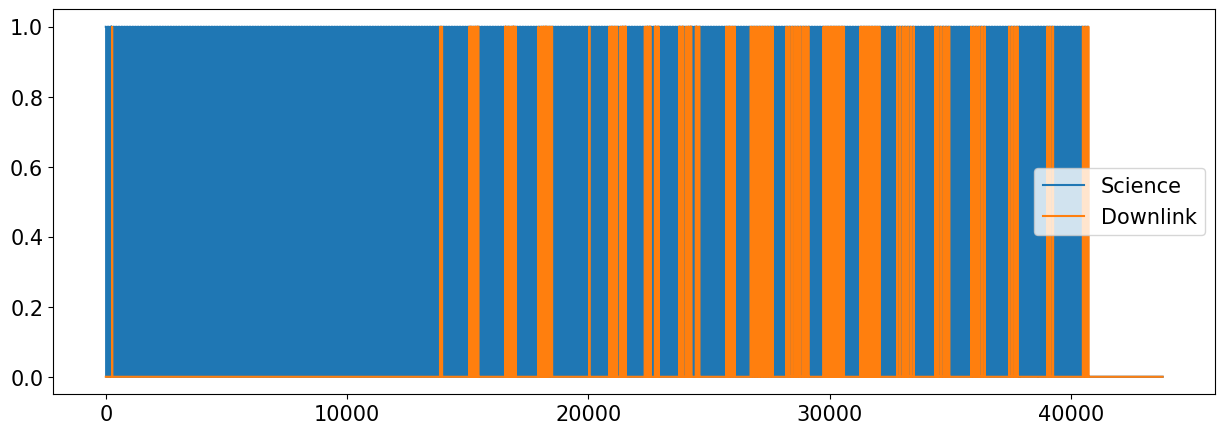

In [238]:
#T_som, T_los, T_GW_los=optimizer.get_data(full_som, full_los, full_GW_los, [indexes[0], indexes[1]])
#T_sc, T_dl, T_gw, T_idle, GS=optimizer.optimize(T_som, T_los, T_GW_los, 0)
plt.figure(figsize = (15,5))
plt.step(range(len(T_sc)), T_sc, label="Science")
plt.step(range(len(T_dl)), T_dl, label="Downlink")
plt.legend()
plt.show()

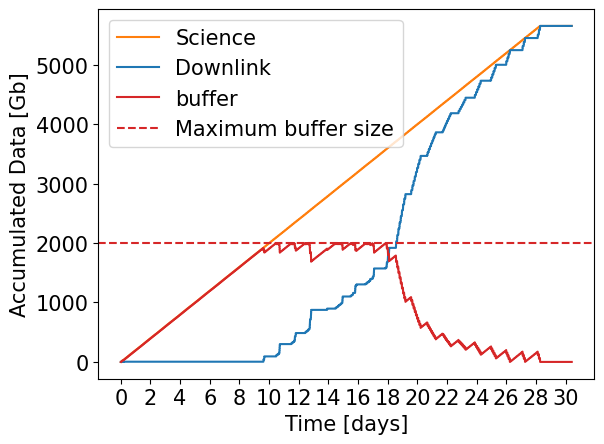

In [245]:
dl_cumsum = np.cumsum(T_dl)*Rdl
sc_cumsum = np.cumsum(T_sc)*Rsc
buffer = sc_cumsum - dl_cumsum
time = range(len(T_dl))
plt.figure()
plt.step(time, sc_cumsum/1e9, label="Science", c='tab:orange')
plt.step(time, dl_cumsum/1e9, label="Downlink",c='tab:blue')
plt.step(time, buffer/1e9, label = "buffer", c='tab:red')
plt.axhline(250*8, c='tab:red', linestyle='--', label='Maximum buffer size')
plt.ylabel("Accumulated Data [Gb]")
plt.xlabel("Time [days]")
ticks = range(0,np.max(time), 2*1440)
plt.xticks(ticks, range(0, 2*len(ticks), 2))
plt.legend()
plt.savefig(f"./raw_{station}_{rho}_downlink_timed.svg", format="svg", bbox_inches="tight")

# Latency calculation

In [240]:
img_size = 3000*4096*12

In [249]:
def discretize_buffer(cumsum, image_size):
    loaded = []
    t_loaded = []
    last_img = 0
    idx = 0
    for i in range(len(cumsum)):
        while cumsum[i] - last_img > image_size:
            last_img += image_size
            loaded.append(idx)
            t_loaded.append(i)
            idx += 1
    return np.array(t_loaded), np.array(loaded)


def get_buffer(sc_t_loaded, sc_loaded, dl_t_loaded, dl_loaded):
    max_time = int(np.max([sc_t_loaded[-1], dl_t_loaded[-1]])) + 1
    time = np.arange(0, max_time, 1)

    scdif = np.diff(np.insert(sc_loaded, 0, 0))
    dldif = np.diff(np.insert(dl_loaded, 0, 0))

    relbuffer = np.zeros_like(time, dtype=np.int32)

    sc_idx = 0
    dl_idx = 0

    for t in range(len(time)):
        while(sc_idx < len(sc_t_loaded) and t == sc_t_loaded[sc_idx]):
            relbuffer[t] += scdif[sc_idx]
            sc_idx += 1
        while(dl_idx < len(dl_t_loaded) and t == dl_t_loaded[dl_idx]):
            relbuffer[t] -= dldif[dl_idx]
            dl_idx += 1
    buffer = np.cumsum(relbuffer)
    return buffer, time


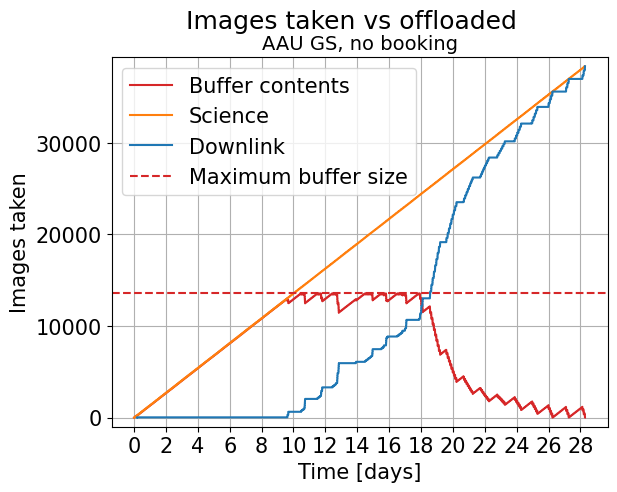

In [250]:
sc_cumsum = np.cumsum(T_sc)*Rsc
dl_total = T_dl * Rdl
dl_cumsum = np.cumsum(dl_total)

sc_t_loaded, sc_loaded = discretize_buffer(sc_cumsum, img_size)
dl_t_loaded, dl_loaded = discretize_buffer(dl_cumsum, img_size)
buffer, time = get_buffer(sc_t_loaded, sc_loaded, dl_t_loaded, dl_loaded)

plt.figure()
plt.step(time, buffer, label = "Buffer contents", c='tab:red')
plt.step(sc_t_loaded, sc_loaded, label="Science", c='tab:orange')
plt.step(dl_t_loaded, dl_loaded, label="Downlink",c='tab:blue')
plt.axhline(250e9*8/img_size, c='tab:red', linestyle='--', label='Maximum buffer size')
plt.ylabel("Images taken")
plt.xlabel("Time [days]")
plt.suptitle("Images taken vs offloaded")
plt.title(f"{station} GS, no booking", fontsize = 14)
plt.ylim(np.min(np.concatenate((sc_loaded,dl_loaded,buffer)))-1000,np.max(np.concatenate((sc_loaded,dl_loaded,buffer)))+1000)
ticks = range(0,np.max(time), 2*1440)
plt.xticks(ticks, range(0, 2*len(ticks), 2))
plt.grid()
plt.legend()
plt.savefig(f"./raw_{station}_{rho}_buffer_over_time.svg", format="svg", bbox_inches="tight")

Max: 10.0139 days
Mean: 5.3292 days
Min: 18 min
Total: 38343 images


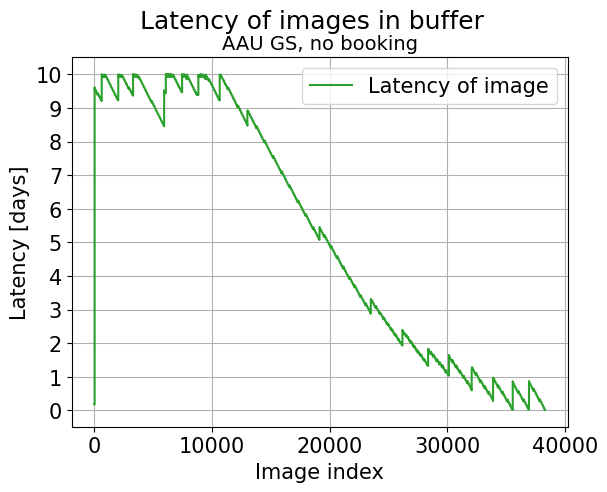

In [251]:
plt.figure()
min_len = min(len(dl_t_loaded), len(sc_t_loaded))
plt.plot(range(min_len), dl_t_loaded[:min_len] - sc_t_loaded[:min_len], label="Latency of image", c='tab:green')
plt.ylabel("Latency [days]")
plt.xlabel("Image index")
plt.grid()
plt.legend()
plt.suptitle("Latency of images in buffer")
plt.title(f"{station} GS, no booking", fontsize = 14)
ticks = range(0,np.max(dl_t_loaded[:min_len] - sc_t_loaded[:min_len])+1000, 1440)
plt.yticks(ticks, range(len(ticks)))
plt.savefig(f"./raw_{station}_{rho}_latency_over_images.svg", format="svg", bbox_inches="tight")
print(f"Max: {np.max(dl_t_loaded[:min_len] - sc_t_loaded[:min_len])/1440:.4f} days")
print(f"Mean: {np.mean(dl_t_loaded[:min_len] - sc_t_loaded[:min_len])/1440:.4f} days")
print(f"Min: {np.min(dl_t_loaded[:min_len] - sc_t_loaded[:min_len])} min")
print(f"Total: {np.max(dl_loaded)} images")